# profilo di verosimiglianza

 * Si generi un campione di N_exp eventi distribuiti secondo una distribuzione di densità di probabilità esponenziale, con lambda = 1/200, compresi fra 0 e 3 volte lambda, ed uno di N_gau eventi distribuiti secondo una distribuzione di densità di probabilità Gaussiana, con media = 190 e sigma = 20

In [1]:
import random
import math
from lib import try_and_catch_exp, try_and_catch_gau

N_exp = 2000
N_gau = 200

In [2]:
sample_exp = try_and_catch_exp (1./200., N_exp)
sample_gau = try_and_catch_gau (190., 20., N_gau)

NameError: name 'random' is not defined

 * Si costruisca un nuovo campione pari all'unione dei due campioni precedenti e se ne disegni un istogramma

In [3]:
sample_tot = sample_exp + sample_gau
print (len (sample_exp))
print (len (sample_gau))
print (len (sample_tot))

random.shuffle (sample_tot)

2000
200
2200


(array([235., 188., 182., 154., 154., 144., 126., 156., 165., 129.,  75.,
         52.,  65.,  41.,  52.,  40.,  32.,  33.,  24.,  23.,  23.,  27.,
         22.,  20.,  16.,  16.,   6.]),
 array([  0.        ,  22.22222222,  44.44444444,  66.66666667,
         88.88888889, 111.11111111, 133.33333333, 155.55555556,
        177.77777778, 200.        , 222.22222222, 244.44444444,
        266.66666667, 288.88888889, 311.11111111, 333.33333333,
        355.55555556, 377.77777778, 400.        , 422.22222222,
        444.44444444, 466.66666667, 488.88888889, 511.11111111,
        533.33333333, 555.55555556, 577.77777778, 600.        ]),
 <BarContainer object of 27 artists>)

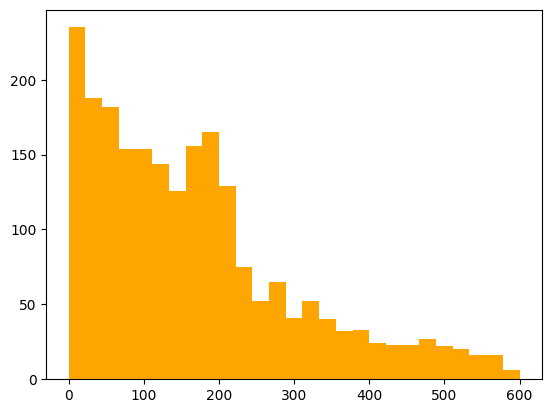

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from lib import sturges

N_bins = sturges (len (sample_tot))

# build a numpy histogram containing the data counts in each bin
bin_content, bin_edges = np.histogram (sample_tot, bins = N_bins, range = (0, 3 * 200.))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (sample_tot,
         bins = bin_edges,
         color = 'orange',
        )

 * si effettui un fit del campione per determinare i parametri del modello

In [5]:
from iminuit import Minuit
from scipy.stats import expon, norm
from iminuit.cost import ExtendedBinnedNLL

def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + \
            N_background * expon.cdf (bin_edges, 0, tau )

from iminuit.cost import ExtendedBinnedNLL
my_cost_func = ExtendedBinnedNLL (bin_content, bin_edges, mod_total)

sample_mean = np.mean (sample_tot)
sample_sigma = np.std (sample_tot)

N_events = sum (bin_content)
my_minuit = Minuit (my_cost_func, 
                    N_signal = N_events, mu = sample_mean, sigma = sample_sigma, # signal input parameters
                    N_background = N_events, tau = sample_mean)                  # background input parameters

my_minuit.migrad ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.74 (χ²/ndof = 0.9)      │              Nfcn = 534              │
│ EDM = 8.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │    196    │    29     │            │            │         │         │       │
│ 1 │ mu           │    186    │     4     │            │            │         │         │       │
│ 2 │ sigma        │   21.1    │    3.4    │            │            │         │         │       │
│ 3 │ N_background │  2.10e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ tau          │    194    │     6     │            │            │         │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │          838          -22           50       -0.7e3          -10 │
│           mu │          -22         12.8           -4           21           -2 │
│        sigma │           50           -4         11.7          -53           -0 │
│ N_background │       -0.7e3           21          -53     3.03e+03           70 │
│          tau │          -10           -2           -0           70         36.5 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

 * si costruisca una funzione che calcoli il logaritmo della verosimiglianza associata al campione, dato un modello f(x) = a * exp (-x/lambda) + b * gauss (x, mean, sigma)

In [6]:
# questi sono i parametri del modello che rimangono fissati
tau = my_minuit.values['tau']
lam = 1/tau
sigma = my_minuit.values['sigma']
gau_norm = 1. / (np.sqrt (2 * np.pi) * sigma)
f_exp = my_minuit.values['N_background']
f_gau = my_minuit.values['N_signal']
f_tot = f_exp + f_gau
f_exp = f_exp / f_tot
f_gau = f_gau / f_tot

def pdf (x, mean):
    return f_exp * lam * np.exp (-x * lam) + \
             f_gau * gau_norm * np.exp (-0.5 * ((x - mean)/sigma )**2)  
           # il simbolo \ serve per andare accapo senza terminare la linea di istruzione

def loglikelihood (theta, pdf, sample) :
    logL = 0.
    for x in sample:
      if (pdf (x, theta) > 0.) : logL = logL + np.log (pdf (x, theta))    
    return logL

 * fissati i parametri del modello al risultato ottenuto dal fit, si calcoli il valore del logaritmo della verosimiglianza per il campione dato il modello, variando il valore del parametro mean, fra 30 e 300, con passo costante e se ne disegni l'andamento (quale passo è ragionevole scegliere per il disegno?)

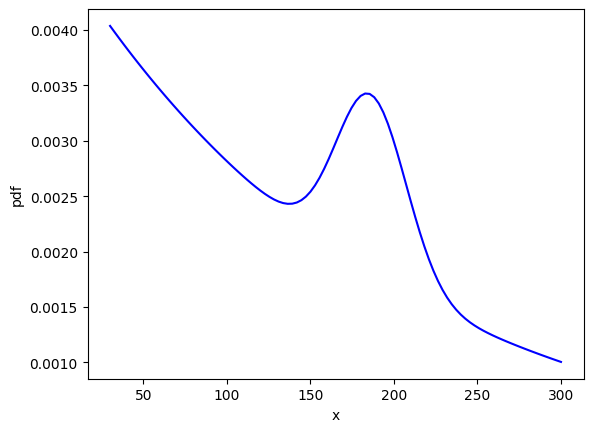

In [7]:
fig, ax = plt.subplots ()
x = np.linspace (30, 300, 100)
ax.plot (x, pdf(x, my_minuit.values['mu']), color = 'blue')
ax.set_xlabel ('x')
ax.set_ylabel ('pdf')
plt.show ()

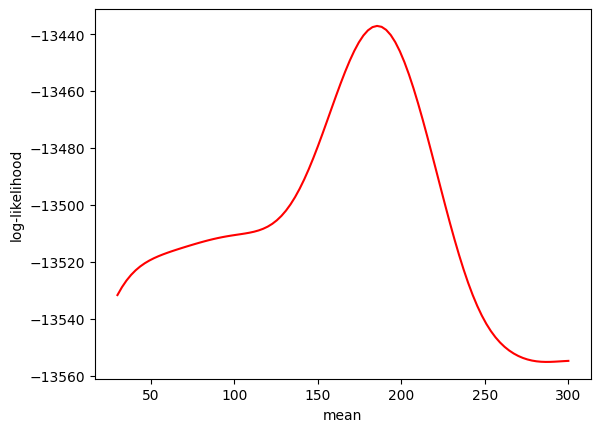

In [8]:
fig, ax = plt.subplots ()

x_coord = np.linspace (30, 300, 100)
l_like = []
for x in x_coord: l_like.append (loglikelihood (x, pdf, sample_tot))   
y_coord = np.array (l_like)

ax.plot (x_coord, y_coord, color = 'red')
ax.set_xlabel ('mean')
ax.set_ylabel ('log-likelihood')
plt.show()

 * si determini il massimo della funzione di verosimiglianza poc'anzi costruita in funzione del parametro mean, utilizzando l'algoritmo della sezione aurea

In [9]:
def sezioneAureaMax (
    x0,             # estremo dell'intervallo          
    x1,             # altro estremo dell'intervallo         
    prec = 0.0001): # precisione della funzione        
    r = 0.618
    x2 = 0.
    x3 = 0. 
     
    while (abs (x1 - x0) > prec):  # x0, x3, x2, x1
        x2 = x0 + r * (x1 - x0) 
        x3 = x0 + (1. - r) * (x1 - x0)  
        if loglikelihood (x3, pdf, sample_tot) < loglikelihood (x2, pdf, sample_tot):
            x0 = x3
        else :
            x1 = x2
    return (x0 + x1) / 2.


In [10]:
mean_maxll = sezioneAureaMax (20, 300, 0.1)
print (f'il valore del parametro mean che massimizza la verosimiglianza è: {mean_maxll:.1f}')

il valore del parametro mean che massimizza la verosimiglianza è: 185.6
